In [1]:
%pip install tensorflow kaggle keras scikit-learn visualkeras keras.utils fastai torchvision keras4torch

Note: you may need to restart the kernel to use updated packages.


In [60]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from keras.models import Model
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from keras.preprocessing.image import ImageDataGenerator
import keras
import time
import h5py
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Reshape
from keras.models import Model
from keras.layers import Conv1D, Conv2D, Conv3D, SeparableConv1D, MaxPooling1D, Activation, MaxPooling2D, Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Conv2D, Dropout
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import layers
from keras.applications import VGG19
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.initializers import RandomNormal
from fastai.basics import untar_data, URLs, Mish, MaxPool, LabelSmoothingCrossEntropy, ranger
import torchvision
import keras4torch as k4t
from torchvision import datasets, models, transforms
from fastai.vision.models.xresnet import *
import resource
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, metrics
import seaborn as sns
import itertools

In [3]:
def rgb2gray(images):
    return np.expand_dims(np.dot(images, [0.2990, 0.5870, 0.1140]), axis=3)

In [22]:
decay_steps = 70 * 8000 // 32
lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=decay_steps,
    decay_rate=0.1,
)

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix', cmap=plt.cm.tab20b):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm. sum (axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product (range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j]> thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [48]:
def create_keras_model():

    keras.backend.clear_session()

    tf.keras.backend.set_image_data_format("channels_last")

    initializer = RandomNormal(mean=0.0, stddev=0.01)
    
    model = Sequential()

    model.add(keras.applications.VGG19(include_top=False,input_shape=(128,128,3), pooling='avg', weights='imagenet'))

    model.add(Flatten())

    model.add(BatchNormalization())

    model.add(Dense(2048, activation='relu', kernel_initializer=initializer))

    model.add(BatchNormalization())

    model.add(Dense(2048, activation='relu', kernel_initializer=initializer))
    
    model.add(Dropout(0.4))

    model.add(Dense(10, activation='softmax'))

    model.layers[0].trainable = False

    optimizer = keras.optimizers.Adam(amsgrad=True, clipnorm=1.0, learning_rate=1e-3)

    model.compile(optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

    return model

***ONLY RUN BELOW IF NO IMAGENET.H5 IS AVAILABLE!***

In [6]:
path = untar_data(URLs.IMAGENETTE_320)
traindir = os.path.join(path, 'train')
valdir = os.path.join(path, 'val')

In [7]:
train_dataset = datasets.ImageFolder(
    traindir,
    transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
)

val_dataset = datasets.ImageFolder(
    valdir,
    transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=False,
    num_workers=1, pin_memory=False)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=127, shuffle=False,
    num_workers=1, pin_memory=False)

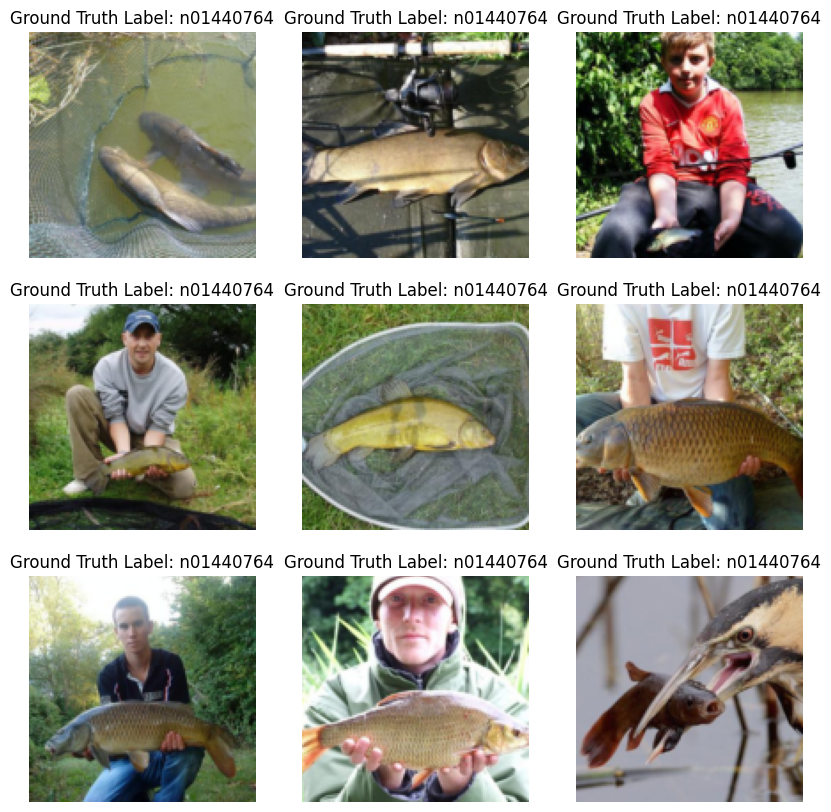

In [11]:
plt.figure(figsize=(10, 10))
sample_images, sample_labels = next(iter(train_loader))
sample_images = sample_images.numpy()
sample_labels = sample_labels.numpy()
for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    image = sample_images[idx].transpose((1, 2, 0))
    plt.imshow(image)
    plt.title("Ground Truth Label: " + class_names[int(sample_labels[idx])])
    plt.axis("off")

In [8]:
X = []
y = []
for batch in train_loader:
    images, labels = batch
    X.append(images.numpy())
    y.append(labels.numpy())
# Combine the list of arrays into a single NumPy array
X_train = np.concatenate(X, axis=0)
y_train = np.concatenate(y, axis=0)
print(X_train.shape)
print(y_train.shape)

(9469, 3, 128, 128)
(9469,)


In [9]:
X = []
y = []
for batch in val_loader:
    images, labels = batch
    X.append(images.numpy())
    y.append(labels.numpy())
# Combine the list of arrays into a single NumPy array
X_test = np.concatenate(X, axis=0)
y_test = np.concatenate(y, axis=0)
print(X_train.shape)
print(y_train.shape)

(9469, 3, 128, 128)
(9469,)


In [11]:
X_train, y_train = X_train.transpose((0,2,3,1)), y_train[:]
X_test, y_test = X_test.transpose((0,2,3,1)), y_test[:]

print("Training Set", X_train.shape)
print("Test Set", X_test.shape)
print("Training Label Set", y_train.shape)
print("Test Label Set", y_test.shape)
print('')

Training Set (9469, 128, 128, 3)
Test Set (3925, 128, 128, 3)
Training Label Set (9469,)
Test Label Set (3925,)



In [12]:
enc = OneHotEncoder().fit(y_train.reshape(-1, 1))

y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
y_test = enc.transform(y_test.reshape(-1, 1)).toarray()

print("Training set", y_train.shape)
print("Test set", y_test.shape)

Training set (9469, 10)
Test set (3925, 10)


In [17]:
h5f = h5py.File('ImageNet_rgb.h5', 'w')
h5f.create_dataset('X_train', data=X_train)
h5f.create_dataset('y_train', data=y_train)
h5f.create_dataset('X_test', data=X_test)
h5f.create_dataset('y_test', data=y_test)
h5f.close()

***RUN FROM HERE IS IMAGENET.H5 IS AVAILABLE***

In [40]:
h5f = h5py.File('ImageNet_rgb.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]

# Close this file
h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (9469, 128, 128, 3) (9469, 10)
Test set (3925, 128, 128, 3) (3925, 10)


In [41]:
datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.15,
                             shear_range=0.2)

In [42]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.3, random_state=23)

In [49]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model_checkpoint = keras.callbacks.ModelCheckpoint(
'best_cnn',
save_best_only=True)

lr_schedule = LearningRateScheduler(lr_scheduler)

model = create_keras_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 2048)              1050624   
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 2048)              4

In [51]:
start = time.time()
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                              epochs=70, validation_data=(X_val, y_val),
                              callbacks=[early_stopping,lr_schedule,model_checkpoint])
end = time.time()
print("CNN ResNet Fit Time: ", end - start,"s")

Epoch 1/70
208/208 [==============================] - ETA: 0s - loss: 1.6136 - accuracy: 0.7228INFO:tensorflow:Assets written to: best_cnn/assets


INFO:tensorflow:Assets written to: best_cnn/assets


208/208 [==============================] - 263s 1s/step - loss: 1.6136 - accuracy: 0.7228 - val_loss: 0.9750 - val_accuracy: 0.6987 - lr: 0.0010
Epoch 2/70
208/208 [==============================] - ETA: 0s - loss: 1.1004 - accuracy: 0.7492INFO:tensorflow:Assets written to: best_cnn/assets


INFO:tensorflow:Assets written to: best_cnn/assets


208/208 [==============================] - 261s 1s/step - loss: 1.1004 - accuracy: 0.7492 - val_loss: 0.8866 - val_accuracy: 0.7980 - lr: 9.9987e-04
Epoch 3/70
208/208 [==============================] - 256s 1s/step - loss: 0.8659 - accuracy: 0.7794 - val_loss: 1.0356 - val_accuracy: 0.8018 - lr: 9.9974e-04
Epoch 4/70
208/208 [==============================] - 257s 1s/step - loss: 0.7492 - accuracy: 0.7962 - val_loss: 1.2487 - val_accuracy: 0.7723 - lr: 9.9961e-04
Epoch 5/70
208/208 [==============================] - 257s 1s/step - loss: 0.6535 - accuracy: 0.8091 - val_loss: 0.9448 - val_accuracy: 0.8054 - lr: 9.9947e-04
Epoch 6/70
208/208 [==============================] - 257s 1s/step - loss: 0.5667 - accuracy: 0.8304 - val_loss: 0.9626 - val_accuracy: 0.8187 - lr: 9.9934e-04
Epoch 7/70
208/208 [==============================] - ETA: 0s - loss: 0.5296 - accuracy: 0.8396INFO:tensorflow:Assets written to: best_cnn/assets


INFO:tensorflow:Assets written to: best_cnn/assets


208/208 [==============================] - 263s 1s/step - loss: 0.5296 - accuracy: 0.8396 - val_loss: 0.7991 - val_accuracy: 0.8321 - lr: 9.9921e-04
Epoch 8/70
208/208 [==============================] - 257s 1s/step - loss: 0.4605 - accuracy: 0.8530 - val_loss: 0.8831 - val_accuracy: 0.8244 - lr: 9.9908e-04
Epoch 9/70
208/208 [==============================] - 257s 1s/step - loss: 0.4412 - accuracy: 0.8633 - val_loss: 0.9621 - val_accuracy: 0.8293 - lr: 9.9895e-04
Epoch 10/70
208/208 [==============================] - 257s 1s/step - loss: 0.4162 - accuracy: 0.8683 - val_loss: 1.0825 - val_accuracy: 0.8251 - lr: 9.9882e-04
Epoch 11/70
208/208 [==============================] - 258s 1s/step - loss: 0.3959 - accuracy: 0.8784 - val_loss: 1.0794 - val_accuracy: 0.8303 - lr: 9.9869e-04
Epoch 12/70
208/208 [==============================] - 258s 1s/step - loss: 0.3646 - accuracy: 0.8861 - val_loss: 0.9379 - val_accuracy: 0.8303 - lr: 9.9855e-04
CNN ResNet Fit Time:  3102.1982131004333 s


In [52]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

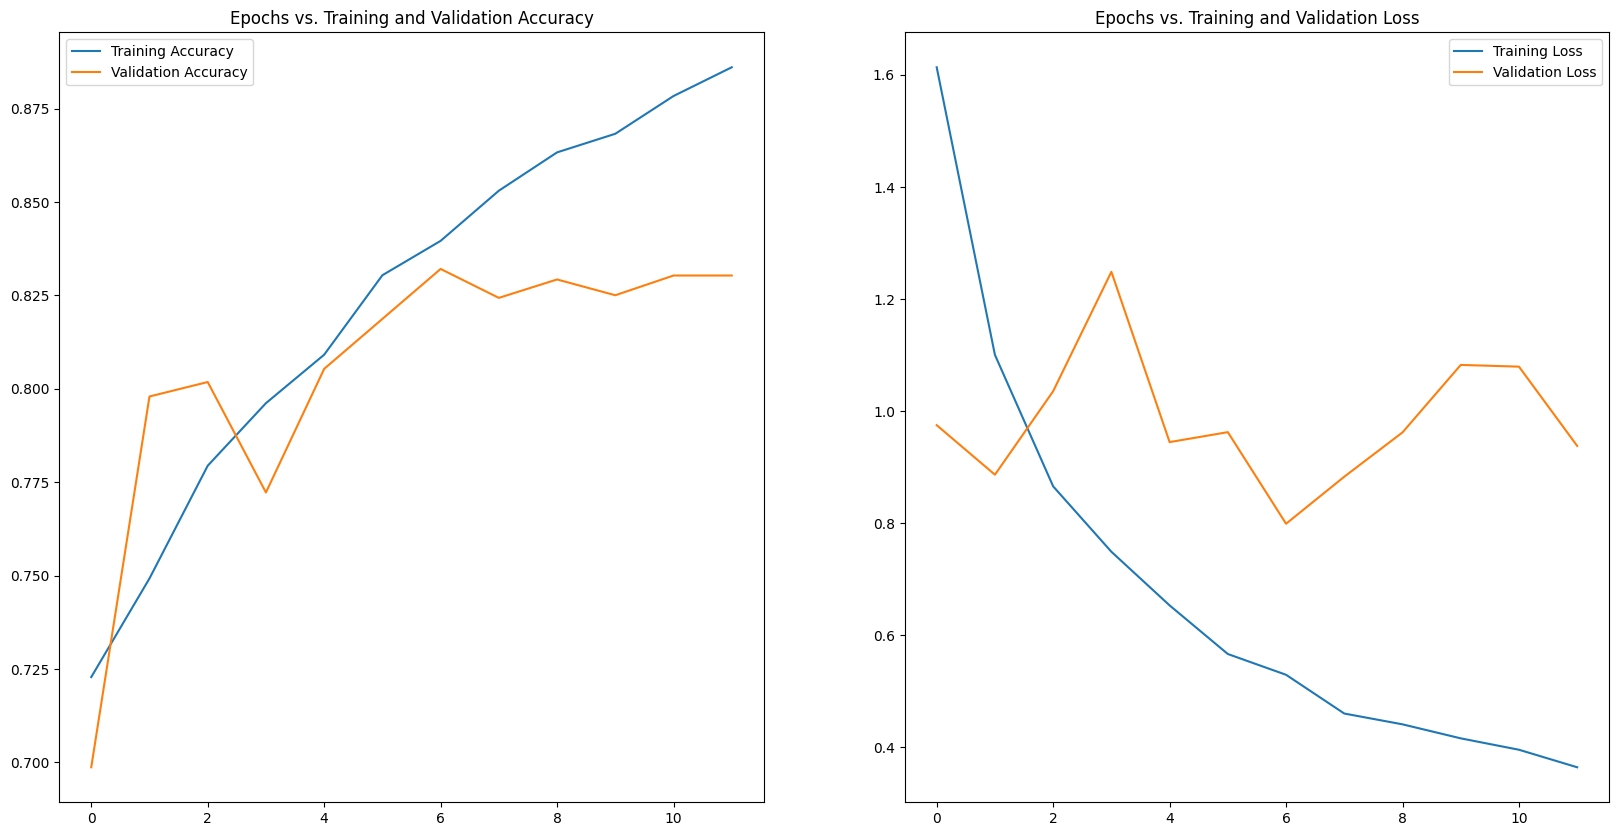

In [53]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

In [54]:
test_loss, test_acc = model.evaluate(x=X_test, y=y_test, verbose=0)
print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.
      format(test_acc, test_loss))

Test accuracy is: 0.8285 
Test loss is: 0.7373


In [55]:
start = time.time()
x_test = X_test
y_true = y_test
y_pred = model.predict(x_test)
y_true_classes = np.argmax(y_true, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
end = time.time()
print("CNN Predict Time: ", end - start,"s")

123/123 [==============================] - 103s 837ms/step
CNN Predict Time:  104.40132665634155 s


Confusion matrix, without normalization
[[323  14   0  29   2  10   2   0   5   2]
 [ 12 306   1  38   6  10   0   1  13   8]
 [  0   2 272  18   0   8  33  20   3   1]
 [  9  10   4 303   3  16  15   4  13   9]
 [  4   1   2   4 371   4  10   7   1   5]
 [  6   4   2  30   4 327   6   8   3   4]
 [  0   7   2  19   8   3 337   9   1   3]
 [  2   0   9  22  16   9  25 333   1   2]
 [ 11   5   2  10   2   6   3   4 355   1]
 [  5   7   3  13   5  14   6   0  12 325]]


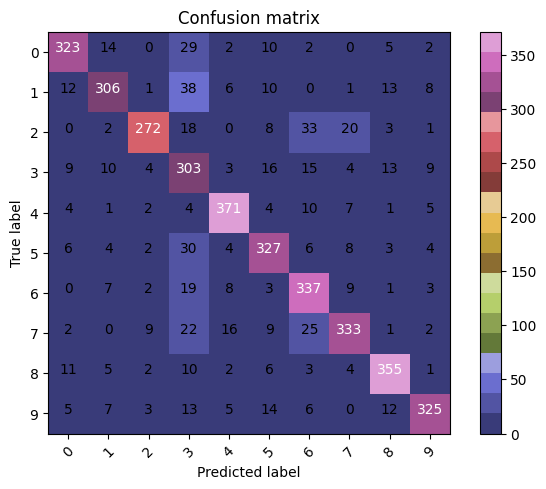

In [61]:
cm = metrics.confusion_matrix(y_true_classes, y_pred_classes)
plot_confusion_matrix(cm, ["0","1","2","3","4","5","6","7","8","9"]) 

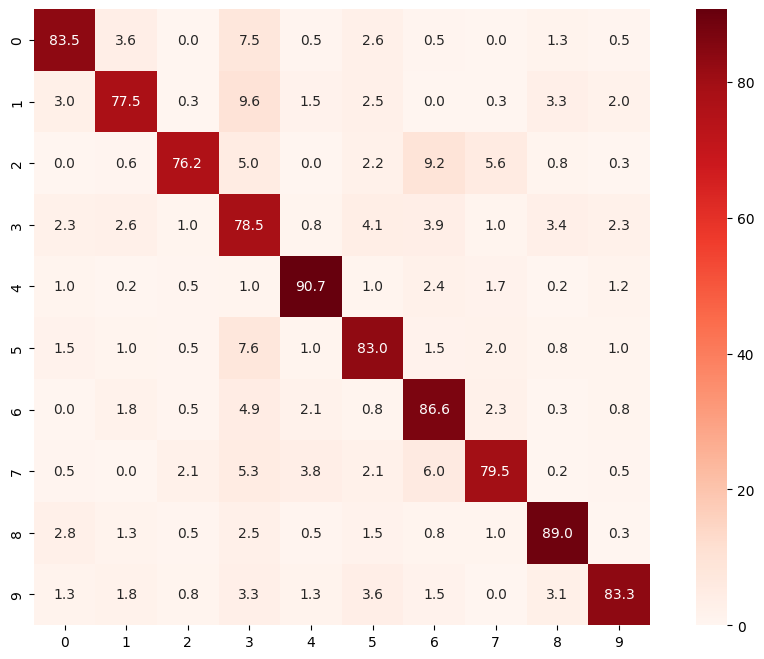

In [62]:
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=y_pred_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.00
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True);